In [1]:
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize

In [19]:
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

In [3]:
from tqdm import tqdm
from MNISTData import MNISTData
from AutoEncoder import AutoEncoder

In [4]:
ENCODING_SIZE = 10
NUM_QUBITS = 10

In [5]:
dev = qml.device("forest.qvm", device="{}q-pyqvm".format(NUM_QUBITS), shots=1600)

In [6]:
from pennylane.ops import RX, RY, CNOT

# x will be a length ENCODING_SIZE vector that represents
# the encoding of a MNIST image
# thetas is of size 2 * NUM_QUBITS
@qml.qnode(dev)
def circuit(x, thetas):
    for i in range(ENCODING_SIZE):
        RX(x[i], wires=i)
    for i in range(NUM_QUBITS - 1):
        CNOT(wires=[i, i+1])
    for i in range(NUM_QUBITS):
        RX(thetas[i], wires=i)
    for i in range(NUM_QUBITS, 2 * NUM_QUBITS):
        RY(thetas[i], wires=(i - NUM_QUBITS))
    return tuple(qml.expval.PauliZ(wires=i) for i in range(NUM_QUBITS))

In [7]:
# example input
print(circuit([np.pi/5]*(ENCODING_SIZE), [np.pi]*(2 * NUM_QUBITS)))

[0.81625 0.66375 0.5475  0.44125 0.3425  0.26875 0.2325  0.19125 0.1775
 0.16875]


In [8]:
def cost(X, actual_labels, thetas):
    b = X.shape[0]
    yhats = []
    for i in range(b):
        yhat = circuit(X[i], thetas)
        yhats.append(yhat)
    st = np.stack(yhats)
    actual_class_vals = st[range(b), actual_labels]
    shifted = st - np.max(st, axis=1)[:, np.newaxis]
    the_sum = np.log(np.sum(np.exp(shifted), axis=1))
    return np.mean(-actual_class_vals + the_sum)

At this point, we have to get our (encoded) images so that we may actually start training

In [9]:
data = MNISTData(batch_size=16)
train_loader = data.get_train_loader()
test_loader = data.get_test_loader()

In [10]:
load_from_stem = "./autoencoder_models/1558731906/"
load_model_from = os.path.join(load_from_stem, "ae.pt")
load_layers_from = os.path.join(load_from_stem, "layer_sizes.pkl")

In [11]:
with open(load_layers_from, 'rb') as f:
    layer_sizes = pickle.load(f)
layer_sizes = layer_sizes[1:]
ae = AutoEncoder(layer_sizes)
ae.load_state_dict(torch.load(load_model_from))
encoder = ae.encoder
for child in encoder.children():
    for param in child.parameters():
        param.requires_grad = False

In [12]:
summary(encoder, input_size=(28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
              ReLU-6                   [-1, 10]               0
Total params: 218,058
Trainable params: 0
Non-trainable params: 218,058
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [13]:
thetas = 2 * np.random.rand(2 * NUM_QUBITS) - 1
print(thetas)
print(thetas.dtype)

[-0.39190764 -0.89033546  0.78817514 -0.86365371 -0.80862228  0.67628685
 -0.66431095 -0.0075417   0.93223902  0.67271833  0.27179479 -0.6076924
 -0.39991273 -0.71364558  0.46744765 -0.06531237  0.48907826 -0.99329663
  0.80115157  0.03453033]
float64


In [14]:
# this is the transformation that you need to do in order
# to pass it to the encoder. it is (1, -1) since the first number
# is the batch size, which in our case is 1
enums = enumerate(train_loader, 0)
i, data = next(enums)
inputs, labels = data
print(inputs.size())
print(len(labels))
print(encoder(inputs[0].view(1, -1)))
print(encoder(inputs[0].view(1, -1)).size())
print(circuit(inputs[0].view(1, -1).numpy(), thetas))

torch.Size([16, 1, 28, 28])
16
tensor([[ 9.3815, 26.1736,  0.0000, 10.7899, 18.9006, 15.2225, 16.0742, 31.9063,
         46.1884,  0.0000]])
torch.Size([1, 10])
[0.69125 0.58    0.495   0.4825  0.4025  0.34875 0.31625 0.3025  0.26375
 0.1475 ]


In [15]:
X = encoder(inputs.view(len(labels), -1))
print(X.size())
print(labels.size())
print(thetas.shape)
start = time.time()
grad = qml.grad(cost, argnum=2)(X.numpy(), labels.numpy(), thetas) 
print(grad)
print(grad.shape)
print(time.time() - start)

torch.Size([16, 10])
torch.Size([16])
(20,)
[-0.15325275 -0.03232135  0.07152199 -0.00609356  0.00629608 -0.00838496
  0.01560962 -0.0047508   0.00661775 -0.01320905  0.09661438 -0.01736152
 -0.01894428 -0.01422447  0.00152138  0.00576268 -0.00030338 -0.00495527
 -0.00055371 -0.00483396]
(20,)
4.47373104095459


In [16]:
def accuracy(thetas, number_batches=3):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader, 0):
        if i == number_batches:
            break
        inputs, labels = data
        inputs = encoder(inputs.view(len(labels), -1)).numpy()
        predicted = []
        for image in inputs:
            ys = circuit(image, thetas)
            predicted.append(np.argmax(ys))
        correct += (np.asarray(predicted) == labels.numpy()).sum()
        total += len(predicted)
    return(correct / total)
# have done no training, so should be around 10%
accuracy(thetas)

0.125

In [17]:
eta = .1
start = time.time()
accuracies = []
for epoch in range(1):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        X = encoder(inputs.view(len(labels), -1))
        grad = qml.grad(cost, argnum=2)(X.numpy(), labels.numpy(), thetas)
        thetas -= eta * grad
        acc = accuracy(thetas)
        accuracies.append(acc)
        print("%d batches took %f seconds and has accuracy %f" % (i + 1, time.time() - start, acc))
        if i == 1000:
            break

1 batches took 4.625762 seconds and has accuracy 0.125000
2 batches took 9.238566 seconds and has accuracy 0.125000
3 batches took 13.858390 seconds and has accuracy 0.104167
4 batches took 18.525776 seconds and has accuracy 0.125000
5 batches took 23.254636 seconds and has accuracy 0.166667
6 batches took 27.839524 seconds and has accuracy 0.083333
7 batches took 32.480444 seconds and has accuracy 0.104167
8 batches took 37.081033 seconds and has accuracy 0.125000
9 batches took 41.661579 seconds and has accuracy 0.083333
10 batches took 46.263892 seconds and has accuracy 0.166667
11 batches took 50.848479 seconds and has accuracy 0.166667
12 batches took 55.452955 seconds and has accuracy 0.145833
13 batches took 60.064976 seconds and has accuracy 0.083333
14 batches took 64.673294 seconds and has accuracy 0.145833
15 batches took 69.307527 seconds and has accuracy 0.125000
16 batches took 73.896502 seconds and has accuracy 0.166667
17 batches took 78.545745 seconds and has accuracy 

136 batches took 627.799965 seconds and has accuracy 0.104167
137 batches took 632.412931 seconds and has accuracy 0.125000
138 batches took 636.999947 seconds and has accuracy 0.145833
139 batches took 641.611217 seconds and has accuracy 0.125000
140 batches took 646.198251 seconds and has accuracy 0.104167
141 batches took 650.801359 seconds and has accuracy 0.125000
142 batches took 655.421250 seconds and has accuracy 0.125000
143 batches took 660.046486 seconds and has accuracy 0.104167
144 batches took 664.653082 seconds and has accuracy 0.145833
145 batches took 669.239595 seconds and has accuracy 0.125000
146 batches took 673.815381 seconds and has accuracy 0.125000
147 batches took 678.387320 seconds and has accuracy 0.104167
148 batches took 683.018100 seconds and has accuracy 0.145833
149 batches took 687.604243 seconds and has accuracy 0.166667
150 batches took 692.214710 seconds and has accuracy 0.104167
151 batches took 696.817763 seconds and has accuracy 0.104167
152 batc

268 batches took 1236.430545 seconds and has accuracy 0.145833
269 batches took 1241.027470 seconds and has accuracy 0.145833
270 batches took 1245.636811 seconds and has accuracy 0.125000
271 batches took 1250.229009 seconds and has accuracy 0.145833
272 batches took 1254.813351 seconds and has accuracy 0.104167
273 batches took 1259.379922 seconds and has accuracy 0.145833
274 batches took 1263.985803 seconds and has accuracy 0.145833
275 batches took 1268.551425 seconds and has accuracy 0.125000
276 batches took 1273.106635 seconds and has accuracy 0.145833
277 batches took 1277.684553 seconds and has accuracy 0.104167
278 batches took 1282.278627 seconds and has accuracy 0.145833
279 batches took 1286.860807 seconds and has accuracy 0.104167
280 batches took 1291.454232 seconds and has accuracy 0.104167
281 batches took 1296.069878 seconds and has accuracy 0.125000
282 batches took 1300.641548 seconds and has accuracy 0.125000
283 batches took 1305.230886 seconds and has accuracy 0

399 batches took 1838.918446 seconds and has accuracy 0.125000
400 batches took 1843.505094 seconds and has accuracy 0.145833
401 batches took 1848.106272 seconds and has accuracy 0.125000
402 batches took 1852.685850 seconds and has accuracy 0.125000
403 batches took 1857.261749 seconds and has accuracy 0.125000
404 batches took 1861.887024 seconds and has accuracy 0.145833
405 batches took 1866.479534 seconds and has accuracy 0.104167
406 batches took 1871.054744 seconds and has accuracy 0.104167
407 batches took 1875.626904 seconds and has accuracy 0.166667
408 batches took 1880.272140 seconds and has accuracy 0.145833
409 batches took 1884.889468 seconds and has accuracy 0.145833
410 batches took 1889.475948 seconds and has accuracy 0.125000
411 batches took 1894.060769 seconds and has accuracy 0.125000
412 batches took 1898.650419 seconds and has accuracy 0.145833
413 batches took 1903.227883 seconds and has accuracy 0.104167
414 batches took 1907.820917 seconds and has accuracy 0

530 batches took 2441.614414 seconds and has accuracy 0.083333
531 batches took 2446.176019 seconds and has accuracy 0.145833
532 batches took 2450.780516 seconds and has accuracy 0.125000
533 batches took 2455.380801 seconds and has accuracy 0.125000
534 batches took 2459.969623 seconds and has accuracy 0.187500
535 batches took 2464.551236 seconds and has accuracy 0.104167
536 batches took 2469.145870 seconds and has accuracy 0.104167
537 batches took 2473.742261 seconds and has accuracy 0.104167
538 batches took 2478.321083 seconds and has accuracy 0.125000
539 batches took 2482.927239 seconds and has accuracy 0.125000
540 batches took 2487.495044 seconds and has accuracy 0.104167
541 batches took 2492.112066 seconds and has accuracy 0.104167
542 batches took 2496.716929 seconds and has accuracy 0.145833
543 batches took 2501.283423 seconds and has accuracy 0.145833
544 batches took 2505.852173 seconds and has accuracy 0.125000
545 batches took 2510.422794 seconds and has accuracy 0

661 batches took 3044.151114 seconds and has accuracy 0.083333
662 batches took 3048.754755 seconds and has accuracy 0.125000
663 batches took 3053.367855 seconds and has accuracy 0.104167
664 batches took 3057.965968 seconds and has accuracy 0.145833
665 batches took 3062.571030 seconds and has accuracy 0.125000
666 batches took 3067.172957 seconds and has accuracy 0.125000
667 batches took 3071.730306 seconds and has accuracy 0.145833
668 batches took 3076.300065 seconds and has accuracy 0.145833
669 batches took 3080.906227 seconds and has accuracy 0.083333
670 batches took 3085.477470 seconds and has accuracy 0.125000
671 batches took 3090.074416 seconds and has accuracy 0.125000
672 batches took 3094.655963 seconds and has accuracy 0.104167
673 batches took 3099.257830 seconds and has accuracy 0.104167
674 batches took 3103.877377 seconds and has accuracy 0.104167
675 batches took 3108.476229 seconds and has accuracy 0.125000
676 batches took 3113.083179 seconds and has accuracy 0

792 batches took 3646.399113 seconds and has accuracy 0.166667
793 batches took 3650.978225 seconds and has accuracy 0.125000
794 batches took 3655.625329 seconds and has accuracy 0.104167
795 batches took 3660.227565 seconds and has accuracy 0.104167
796 batches took 3664.837073 seconds and has accuracy 0.125000
797 batches took 3669.449533 seconds and has accuracy 0.145833
798 batches took 3674.071184 seconds and has accuracy 0.145833
799 batches took 3678.680940 seconds and has accuracy 0.125000
800 batches took 3683.325405 seconds and has accuracy 0.104167
801 batches took 3687.892992 seconds and has accuracy 0.104167
802 batches took 3692.497543 seconds and has accuracy 0.104167
803 batches took 3697.116953 seconds and has accuracy 0.083333
804 batches took 3701.702317 seconds and has accuracy 0.104167
805 batches took 3706.271222 seconds and has accuracy 0.187500
806 batches took 3710.847315 seconds and has accuracy 0.125000
807 batches took 3715.409666 seconds and has accuracy 0

923 batches took 4248.728085 seconds and has accuracy 0.083333
924 batches took 4253.351262 seconds and has accuracy 0.104167
925 batches took 4257.937119 seconds and has accuracy 0.145833
926 batches took 4262.538845 seconds and has accuracy 0.166667
927 batches took 4267.118553 seconds and has accuracy 0.104167
928 batches took 4271.692001 seconds and has accuracy 0.166667
929 batches took 4276.262738 seconds and has accuracy 0.125000
930 batches took 4280.835072 seconds and has accuracy 0.145833
931 batches took 4285.500810 seconds and has accuracy 0.125000
932 batches took 4290.120711 seconds and has accuracy 0.145833
933 batches took 4294.678082 seconds and has accuracy 0.145833
934 batches took 4299.285760 seconds and has accuracy 0.125000
935 batches took 4303.858586 seconds and has accuracy 0.104167
936 batches took 4308.460076 seconds and has accuracy 0.166667
937 batches took 4313.021621 seconds and has accuracy 0.125000
938 batches took 4317.608785 seconds and has accuracy 0

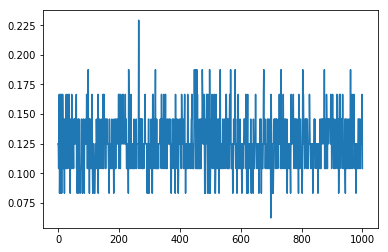

[ 1.39768982e-03 -1.19032036e+00  6.17837244e-04 -1.28231471e-01
 -5.15572525e-01  5.25862676e-01 -6.39528462e-01  2.24591655e-02
  9.41528001e-01  6.92911103e-01  1.02051764e-03 -7.29652667e-01
  1.52306997e-03 -1.01740002e-01  2.97348633e-01 -6.52809914e-02
  4.53818462e-01 -1.01226215e+00  8.23224702e-01  5.55855328e-02]


In [21]:
plt.plot(accuracies)
plt.show()
print(thetas)